In [2]:
# !pip install python-dotenv
# !pip install openai
# !pip install --upgrade langchain

In [31]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [36]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, 
    )
    return response.choices[0].message["content"]

In [37]:
get_completion("What is 1+1?")

'As an AI language model, I can tell you that the answer to 1+1 is 2.'

## Prompt template

In [6]:
from langchain.prompts import ChatPromptTemplate

template_string= """"

Generate a {style} related to the topic in the text.
text:{text} 
"""
prompt_template = ChatPromptTemplate.from_template(template_string)

In [7]:
prompt_template

ChatPromptTemplate(input_variables=['style', 'text'], output_parser=None, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['style', 'text'], output_parser=None, partial_variables={}, template='"\n\nGenerate a {style} related to the topic in the text.\ntext:{text} \n', template_format='f-string', validate_template=True), additional_kwargs={})])

In [8]:
prompt_template.input_variables

['style', 'text']

In [9]:
style="flash cards"

text= "Computer science and its part in geology"

customer_messages = prompt_template.format_messages(
                    style=style,
                    text=text)
customer_messages

[HumanMessage(content='"\n\nGenerate a flash cards related to the topic in the text.\ntext:Computer science and its part in geology \n', additional_kwargs={}, example=False)]

```python
customer_response = chat(customer_messages)
print(customer_response.content)
```

output:
1. Computer Science: The study of computers and computational systems.
2. Geology: The study of the Earth's physical structure, substance, and history.
3. Geographic Information Systems (GIS): Computer systems used to capture, store, manipulate, analyze, manage, and present spatial or geographic data.
4. Remote Sensing: The acquisition of information about the Earth's surface using sensors mounted on aircraft or satellites.
5. Data Mining: The process of discovering patterns in large data sets using computational techniques.
6. Machine Learning: A type of artificial intelligence that allows computers to learn and improve from experience without being explicitly programmed.
7. Modeling and Simulation: The use of computer models to simulate real-world phenomena and predict outcomes.
8. Big Data: Extremely large data sets that can be analyzed computationally to reveal patterns, trends, and associations.
9. Computational Fluid Dynamics (CFD): The use of computer simulations to analyze and solve problems related to fluid flow.
10. Digital Mapping: The creation of digital maps using computer software and data.

In [10]:
style="Q&A"

text= "Computer science and its part in geology"

customer_messages = prompt_template.format_messages(
                    style=style,
                    text=text)

print(customer_messages[0])

content='"\n\nGenerate a Q&A related to the topic in the text.\ntext:Computer science and its part in geology \n' additional_kwargs={} example=False


```python
customer_response = chat(customer_messages)
print(customer_response.content)
```

**Ouptut:**  
Q: What is the role of computer science in geology?
A: Computer science plays a crucial role in geology by providing tools and techniques for data analysis, modeling, and visualization. It helps geologists to process large amounts of data, simulate complex geological processes, and create accurate maps and models of the Earth's subsurface. 

Q: How does computer science help in the exploration of natural resources?
A: Computer science helps in the exploration of natural resources by enabling geologists to analyze geological data and identify potential mineral deposits, oil and gas reservoirs, and groundwater resources. It also helps in the planning and management of mining operations, drilling activities, and environmental monitoring. 

### Why are we using prompt templates instead of f string
As you build sophisticated applications, prompts can be long and messy.   
So prompt template is a useful abstraction to resue templates whenever is needed.

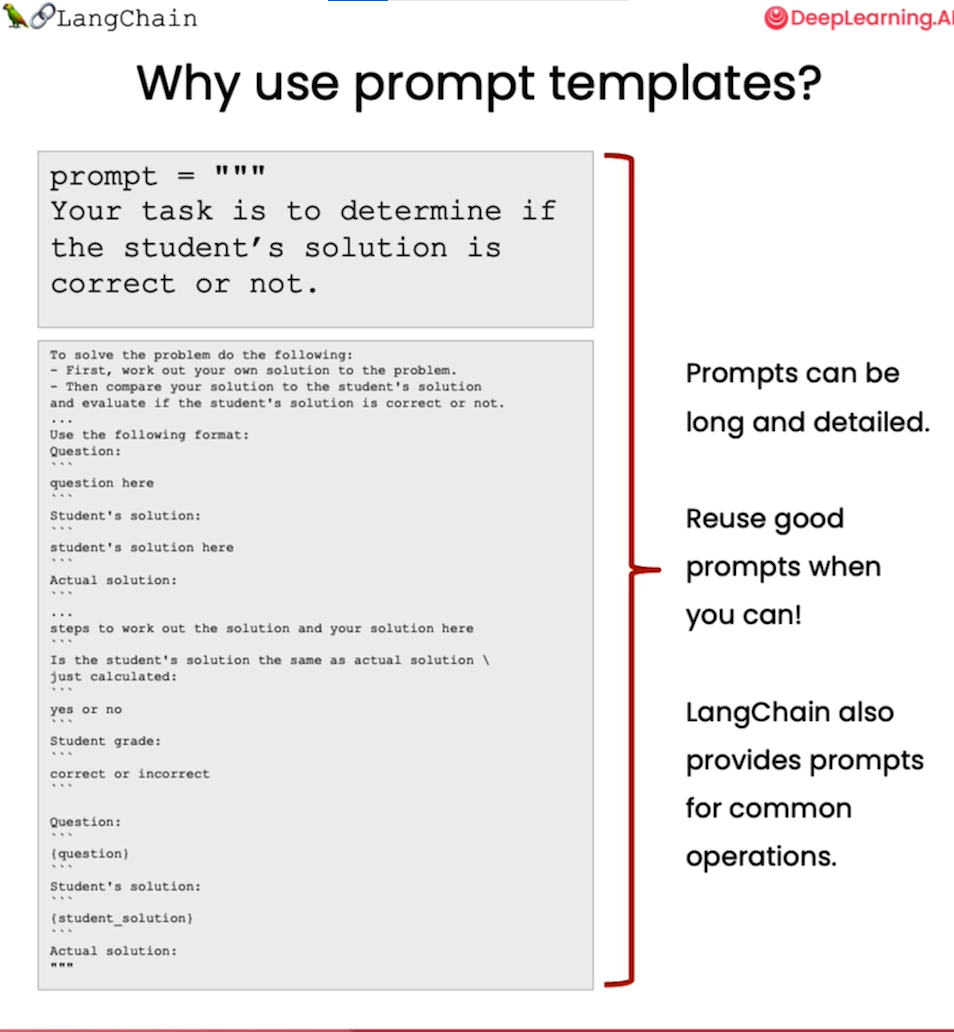

## Output Parsers

Let's start with defining how we would like the LLM output to look like:

```json
{
  "gift": False,
  "delivery_days": 5,
  "price_value": "pretty affordable!"
}
```

Suppose we want to extract info from reviews in a json format

In [11]:
customer_review = """\
This leaf blower is pretty amazing.  It has four settings:\
candle blower, gentle breeze, windy city, and tornado. \
It arrived in two days, just in time for my wife's \
anniversary present. \
I think my wife liked it so much she was speechless. \
So far I've been the only one using it, and I've been \
using it every other morning to clear the leaves on our lawn. \
It's slightly more expensive than the other leaf blowers \
out there, but I think it's worth it for the extra features.
"""

review_template = """\
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? \
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product \
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,\
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}
"""

In [12]:
prompt_template = ChatPromptTemplate.from_template(review_template)
print(prompt_template.messages[0].prompt.template)
print(prompt_template.messages[0].input_variables)
print(prompt_template.messages[0])

For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}

['text']
prompt=PromptTemplate(input_variables=['text'], output_parser=None, partial_variables={}, template='For the following text, extract the following information:\n\ngift: Was the item purchased as a gift for someone else? Answer True if yes, False if not or unknown.\n\ndelivery_days: How many days did it take for the product to arrive? If this information is not found, output -1.\n\nprice_value: Extract any sentences about the value or price,and output them as a comma separated Python list.\n\nFormat the

```python
messages = prompt_template.format_messages(text=customer_review)
chat = ChatOpenAI(temperature=0.0)
response = chat(messages)
print(response.content)
```
**Output:**  
{
    "gift": true,
    "delivery_days": 2,
    "price_value": ["It's slightly more expensive than the other leaf blowers out there, but I think it's worth it for the extra features."]
}


In [13]:
response='''{
    "gift": true,
    "delivery_days": 2,
    "price_value": ["It's slightly more expensive than the other leaf blowers out there, but I think it's worth it for the extra features."]
}'''

# You will get an error by running this line of code 
# because'gift' is not a dictionary
# 'gift' is a string

print(type(response))
response.get('g')

<class 'str'>


AttributeError: 'str' object has no attribute 'get'

### Parse the LLM output string into a Python dictionary

In [14]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

In [15]:
gift_schema = ResponseSchema(name="gift",
                             description="Was the item purchased\
                             as a gift for someone else? \
                             Answer True if yes,\
                             False if not or unknown.")
delivery_days_schema = ResponseSchema(name="delivery_days",
                                      description="How many days\
                                      did it take for the product\
                                      to arrive? If this \
                                      information is not found,\
                                      output -1.")
price_value_schema = ResponseSchema(name="price_value",
                                    description="Extract any\
                                    sentences about the value or \
                                    price, and output them as a \
                                    comma separated Python list.")

response_schemas = [gift_schema, 
                    delivery_days_schema,
                    price_value_schema]

In [16]:
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
output_parser

StructuredOutputParser(response_schemas=[ResponseSchema(name='gift', description='Was the item purchased                             as a gift for someone else?                              Answer True if yes,                             False if not or unknown.', type='string'), ResponseSchema(name='delivery_days', description='How many days                                      did it take for the product                                      to arrive? If this                                       information is not found,                                      output -1.', type='string'), ResponseSchema(name='price_value', description='Extract any                                    sentences about the value or                                     price, and output them as a                                     comma separated Python list.', type='string')])

In [17]:
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"gift": string  // Was the item purchased                             as a gift for someone else?                              Answer True if yes,                             False if not or unknown.
	"delivery_days": string  // How many days                                      did it take for the product                                      to arrive? If this                                       information is not found,                                      output -1.
	"price_value": string  // Extract any                                    sentences about the value or                                     price, and output them as a                                     comma separated Python list.
}
```


In [25]:
review_template_2 = """\
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? \
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product\
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,\
and output them as a comma separated Python list.

text: {text}

{format_instructions}
"""

prompt = ChatPromptTemplate.from_template(template=review_template_2)

messages = prompt.format_messages(text=customer_review, 
                                format_instructions=format_instructions)


In [27]:
print(messages[0].content)

For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the productto arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,and output them as a comma separated Python list.

text: This leaf blower is pretty amazing.  It has four settings:candle blower, gentle breeze, windy city, and tornado. It arrived in two days, just in time for my wife's anniversary present. I think my wife liked it so much she was speechless. So far I've been the only one using it, and I've been using it every other morning to clear the leaves on our lawn. It's slightly more expensive than the other leaf blowers out there, but I think it's worth it for the extra features.


The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```

```python
response = chat(messages)
print(response.content)
```
**Output:**

'''json
{
	"gift": true,
	"delivery_days": "2",
	"price_value": ["It's slightly more expensive than the other leaf blowers out there, but I think it's worth it for the extra features."]
}
'''

```python
output_dict = output_parser.parse(response.content)
output_dict.get('delivery_days')
```

**Output:**

'2'